## ATL03 Open data and simple plot of pulse

This notebook is for pening data with hdf5 and simple visualisation of the photons per one pulse. Created for Unsupervised Surface Classification procject at Hackweek 2020

**This file must be finished with plotting the correct variables, currently sigma_h is plotted**

List the downloaded data files and read in data from one of them.

In [11]:
import h5py
import numpy as np
from pathlib import Path
import pyproj
%matplotlib inline

In [4]:
#Here specify path to data 
data_home = Path('/home/jovyan/unsupervised_project/download/')

In [5]:
files = list(data_home.glob('*.h5'))
print(files) #list files in directory

[PosixPath('/home/jovyan/unsupervised_project/download/processed_ATL03_20190525195203_08790305_003_01.h5'), PosixPath('/home/jovyan/unsupervised_project/download/processed_ATL03_20190529194342_09400305_003_01.h5')]


To investigate the structure of the file we can vie the dictionary:

In [6]:
!h5ls -r {files[0]} 

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC01  Group
/METADATA/Lineage/ANC03  Group
/METADATA/Lineage/ANC04  Group
/METADATA/Lineage/ANC05  Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC07  Group
/METADATA/Lineage/ANC08  Group
/METADATA/Lineage/ANC11  Group
/METADATA/Lineage/ANC12-01 Group
/METADATA/Lineage/ANC12-02 Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC22  Group
/METADATA/Lineage/ANC23  Gr

Create a reader to read in the data, extract variables and save them per track in seperate files:

In [7]:
def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert



def read_atl03(fname, outdir='data'):
    """Read one ATL03 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL03 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):
    
        #-----------------------------------#
        # Read in data for a single beam #
        #-----------------------------------#
        
        data = {}
    
        try:
            # Load vars into memory (include as many as you want)
            with h5py.File(fname, 'r') as fi:
                
                data['lat'] = fi[g+'/geolocation/sigma_lat'][:]
                data['lon'] = fi[g+'/geolocation/sigma_lon'][:]
                data['height'] = fi[g+'/geolocation/sigma_h'][:]
                data['surf_type'] = fi[g+'/geolocation/surf_type'][:]

                
                
        except:
            print('skeeping group:', g)
            print('in file:', fname)
            continue
 
        #-----------------------#
        # Convert Coordinates #
        #-----------------------#
        
        # Geodetic lon/lat -> Polar Stereo x/y
        x, y = transform_coord(4326, 3031, data['lon'], data['lat'])
        
        data['x'] = x
        data['y'] = y
        
        
        #-----------------------#
        # Save selected data #
        #-----------------------#
        
        # Define output dir and file
        outdir = Path(outdir)    
        fname = Path(fname)
        outdir.mkdir(exist_ok=True)
        outfile = outdir / fname.name.replace('.h5', '_' + g[1:] + '.h5')
        
        # Save variables
        with h5py.File(outfile, 'w') as fo:
            for k, v in data.items(): fo[k] = v
            print('out ->', outfile)
 
   
              

In [8]:
#Here specify outdir 
outdir = Path('/home/jovyan/unsupervised_project/data/')

outdir.mkdir(exist_ok=True)

Run the reader:

In [12]:
njobs = 8

if njobs == 1:
    print('running in serial ...')
    [read_atl03(f, outdir) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl03)(f, outdir) for f in files)



running in parallel (8 jobs) ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished


Checking created files:

In [13]:
#outfiles = !ls {outdir}/*.h5
outfiles = list(outdir.glob('*.h5'))

for f in outfiles[:10]: print(f)
print('Total number of files:', len(outfiles))

/home/jovyan/unsupervised_project/data/processed_ATL03_20190525195203_08790305_003_01_gt2r.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190529194342_09400305_003_01_gt2r.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190525195203_08790305_003_01_gt2l.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190529194342_09400305_003_01_gt2l.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190525195203_08790305_003_01_gt3r.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190525195203_08790305_003_01_gt1l.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190529194342_09400305_003_01_gt1l.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190529194342_09400305_003_01_gt3r.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190525195203_08790305_003_01_gt3l.h5
/home/jovyan/unsupervised_project/data/processed_ATL03_20190529194342_09400305_003_01_gt1r.h5
Total number of files: 12


Let's check if the expected variables are in the file, and how many measurements we have.

In [14]:
!h5ls -r {outfiles[0]}

/                        Group
/height                  Dataset {4332}
/lat                     Dataset {4332}
/lon                     Dataset {4332}
/surf_type               Dataset {4332, 5}
/x                       Dataset {4332}
/y                       Dataset {4332}


## Reading one of the files and plotting sigma

In [61]:
def read_atl03_track(fname):
       
    import pandas as pd
    data = pd.DataFrame()
    
    with h5py.File(fname, 'r') as fi:
         
        data['x'] = fi['x'][:]
        data['y'] = fi['y'][:]
        data['height'] = fi['height'][:]
        return data

In [62]:
import pandas as pd

file = list(outdir.glob('*.h5'))[0]

data = read_atl03_track(file)

print(data)

              x             y  height
0     25.122796  1.236743e+07     0.3
1     25.128029  1.236743e+07     0.3
2     25.133261  1.236743e+07     0.3
3     25.138490  1.236743e+07     0.3
4     25.143719  1.236743e+07     0.3
...         ...           ...     ...
4327  38.687569  1.236743e+07     0.3
4328  38.688267  1.236743e+07     0.3
4329  38.688967  1.236743e+07     0.3
4330  38.689690  1.236743e+07     0.3
4331  38.690387  1.236743e+07     0.3

[4332 rows x 3 columns]


Plotting the data:

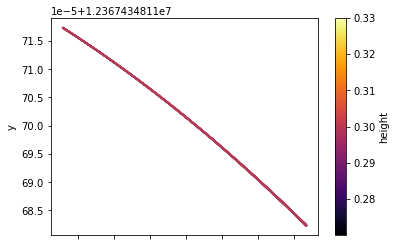

In [63]:
data.plot(x='x', y='y', kind='scatter', c='height', s=1, cmap='inferno')

clearly I have downloaded the wrong parameter here, instead of the photon point cloud I have height